# Evolução Numérica da Métrica de Schwarzschild
## Aluno: Arthur Diniz Meirelles
## RA: 23202420703
## Maio de 2025

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Na relatividade numérica buscamos reformular as equações de campo de Einstein em uma forma que pode ser integrada numericamente. Para isso, decompomos a métrica $g_{ab}$ na sua métrica espacial $\gamma_{ab}$ e na chamada curvatura extrínseca $K_{ab}$:

\begin{align}
    \gamma_{ab}&=g_{ab}+n_an_b & K_{ab}&=-\gamma_a^c \gamma_b^d \nabla_c n_d
\end{align}

e usamos essas novas quantidades para reescrever as equações de campo e da geodésica na forma de equações diferenciais parciais de vínculo e de evolução denominadas equações ADM.

Essas equações, porém, possuem dois problemas:

- Para métricas com singularidades de coordenadas, o uso dessas equações pode levar a overflows e outros tipos de mal comportamento;
- Em geral, essas equações não são hiperbólicas, o que do ponto de vista numérico leva a instabilidade nas evoluções.

Por conta disso, não se resolve de forma única diretamente pelas equações ADM na sua forma geral qualquer sistema, busca-se primeiro a regularização e a hiperbolarização dessas equações para cada sistema. Sendo assim, uma única classe ou função genérica capaz de resolver qualquer problema de relatividade numérica não pode ser construída sem uma quantidade inconveniente de grandes blocos condicionais, e um software dedicado a resolver problemas diversificados nessa área tende a ser muito grande para o contexto desse projeto.

Por conta disso, eu apresentarei aqui de forma muito resumida uma abordagem que podemos usar para evoluir a métrica de Schwarzschild numericamente, uma situação física onde não acontece nada ao longo do tempo, mas que já pode mostrar como as quantidades numéricas necessárias para a evolução são sensíveis nesse problema.

Utilizamos a métrica de Schwarzschild em coordenadas isotrópicas:

$$ ds^2=-\alpha^2dt^2+\psi^4(dr^2+r^2d\Omega^2) $$

onde $\psi=1+M/2r$, onde $r$ está relacionado ao raio de Schwarschild como $r_s=r\psi^2$.

Seguindo a abordagem do livro Introduction to 3+1 Numerical Relativity de Miguel Alcubierre, temos as seguintes equações de evolução, ignorando termos de matéria:

\begin{equation}
    \partial_t \tilde{D}_A = -2\alpha(K_A D_\alpha + \partial_r K_A)
\end{equation}

\begin{equation}
    \partial_t \tilde{D}_B = -2\alpha(K_B D_\alpha + \partial_r K_B)
\end{equation}

\begin{equation}
        \partial_t K_A =
\end{equation}

\begin{equation}
        \partial_t K_B=
\end{equation}

\begin{equation}
    \partial_t \lambda = \frac{2\alpha \tilde{A}}{\tilde{B}}\left(\partial_r K_B-\frac{(\tilde{D}_B+4\partial_r\ln{\psi})(K_A-K_B)}{2}\right)
\end{equation}

onde (PREENCHER AQUI AS DEFINIÇÕES DAS VARIÁVEIS)

As equações de vínculo nessas condições são:

\begin{equation}
    \begin{split}
        H=&-\partial_rD_B-\frac{\lambda}{r}+AK_B(2K_A+K_B)\\
        &+\frac{1}{r}(D_A-3D_B)+\frac{D_AD_B}{2}-\frac{3D_B^2}{4}-8\pi A\rho=0
    \end{split}
\end{equation}
\begin{equation}
    M=-\partial_r K_B+(K_A-K_B)\left(\frac{1}{r}+\frac{D_B}{2}\right)-4\pi j_A=0
\end{equation}

e elas devem ser verdadeiras (dentro de um erro numérico) em todos os passos de tempo, por isso serão usadas para verificar se a integração está funcionando de forma precisa.

O design que eu vou usar é o seguinte: EXPLICAR DEPOIS DE PREPARAR A ESTRUTURA BÁSICA DO CÓDIGO

In [6]:
def psi(r, M=1):
    # Isotropic coordinates function
    
    return 1+M/(2*r)

In [12]:
# Spatial grid variables:

class GridVar:
    '''
    Every variable in the simulation is a scalar function A(r,t), for every time slice these variables can be represented as vectors A_r(t)
    Every variable in the simulation will be defined within the same grid and will have similar behaviors within that grid, so this class
    defines these common properties based on the size of the grid.
    
    Attributes:
        drs ( np.array (N-1, ) ): drs[i]=rs[i+1]-rs[i] up to i=len(rs)-1
        rs ( np.array (N, ) ): Values of r in the interval
        vals ( np.array (N, ) ): Values of the variable for each r

    Methods:
        d_dr(self): Returns the np.array of numerical derivatives of the variable along the grid
        int_dr(self, int0): Returns the np.array of numerical integration along the grid (sets the first element to int0) 
        Dunder methods: __init__, __mul__, __rmul__, __add__.
    '''
    
    def __init__(self, vals, rs):

        self.rs = rs
        self.drs = self.rs[1:]-self.rs[:-1]
        self.vals = vals

    def d_dr(self, bounds = None):
        '''
        Returns a np.array with the spatial derivatives of vals
        If given, bounds has to be a 2-element (number) list, tuple or array
        '''

        diff = np.zeros(len(self.vals))
        
        if bounds == None:
            diff[0] = (self.vals[1]-self.vals[0])/self.drs[0]
            diff[-1] = (self.vals[-1]-self.vals[-2])/self.drs[-1]
        else:
            diff[0], diff[-1] = bounds[0], bounds[1]

        # Central difference algorithm for numerical derivative:

        diff[1:-1] = (self.vals[2:] - self.vals[:-2]) / (2 * self.drs[:-1])
        
        return GridVar(diff, self.rs)

    def int_dr(self, bound):
        '''
        Returns a np.array with the spatial integral of vals, given an initial value integral[0]
        '''
        
        integral = np.zeros(len(self.vals))
        integral[0]=bound
    
        for i in range(len(self.vals)-1):
            integral[i+1]=integral[i]+0.5*self.drs[i]*(self.vals[i]+self.vals[i+1]) #trapezoid rule

        return GridVar(integral, self.rs)

    def __mul__(self, lbda):
        # Behavior under the syntax lbda*instance, lbda can be both a GridVar object or a number
        # Breaks if lbda is a GridVar instance with a different rs array: can only operate on identical grids.
        if isinstance(lbda, GridVar):
            if not np.allclose(lbda.rs, self.rs):
                raise ValueError("You can only multiply GridVars with the exact same r grid!")

        vec = lbda*self.vals
        rs = self.rs

        return GridVar(vec, rs)

    def __rmul__(self, lbda):
        # Behavior under the syntax instance*lbda, so the code doesn't break if instance*number is called

        return self.__mul__(lbda)

    def __add__(self, other):
        # Behavior under the syntax instance1+instance2
        # __radd__ is not necessary, if both objects are GridVar instances, the order of the operation won't change the result
        if isinstance(other, GridVar) and np.allclose(self.rs, other.rs):
            vec = self.vals+other.vals
            rs = self.rs

            return GridVar(vec, rs)
        else:
            raise ValueError("GridVar objects can only sum over other GridVar objects with the exact same r grid.")

    def __truediv__(self, other):
        if isinstance(other, GridVar) and np.allclose(self.rs, other.rs):
            vec = self.vals/other.vals
            rs = self.rs

            return GridVar(vec, rs)
        elif (type(other) == int) or (type(other) == float):
            vec = self.vals/other
            rs = self.rs

            return GridVar(vec, rs)
        else:
            raise ValueError('GridVar can only be divided by numbers, array or other GridVar instance with the same grid (rs)!')

    def __repr__(self):
        return repr(self.vals) #when called is presented as the numpy array

    def __pow__(self, exponent):
        #behavior under syntax instance**exponent
        vec = np.power(self.vals, exponent)
        rs = self.rs

        return GridVar(vec, rs)

In [53]:
class Grid:
    '''
    Defines the grid itself for each time slice. Contains all variables required to describe a spatial slice. Here we assume the Bona-Lasso
    slicing condition.

    Args:
        rs ( np.array (N, ) ): Values of r 'labeled' in the grid, the user has to be careful with this definition
        Nr (int): Length of rs.
        tDa, tDb, Ka and Kb are assumed to be float numpy arrays shaped (N,).
        tA, tB, lbda and alpha are calculated from the previous variables

    Methods:
        A_calculate(self): Calculates A from tA and psi
        B_calculate(self): Calculates B from tB and psi
        lbda_calculate(self): Calculates lbda from other variables
        alpha_calculate(self, bound): Given a boundary condition, calculates alpha from Dalpha
        Evolution functions evaluate the expressions for d(var)/dt: dtU, dtK, dtDalpha, dtlbda, dtDb, dtKb
        These functions evaluate the hamilton and momentum constraints: Hamilton_const() and Momentum_const()
    '''

    def __init__(self, rs, tDa, tDb, Ka, Kb):

        #grid properties:
        self.rs = rs
        self.Nr = len(rs)
        self.psi = GridVar(psi(rs), rs) #using M=1 for now
        
        #simulation variables:
        self.tDa = GridVar(tDa, rs)
        self.tDb = GridVar(tDb, rs)
        self.Ka = GridVar(Ka, rs)
        self.Kb = GridVar(Kb, rs)

        #obtainable variables:
        self.tA = self.tA_calculate()
        self.tB = self.tB_calculate()
        self.lbda = self.lbda_calculate()
        self.alpha = self.alpha_calculate()
        self.Dalpha = self.Dalpha_calculate()

        self.dr_lnpsi = GridVar(np.log(self.psi.vals), self.rs).d_dr() #this variable is used many times 
        # defining it here may save some time

    def tA_calculate(self):
        return None
        
    def tB_calculate(self):
        return None

    def alpha_calculate(self, bounds=None):
        return None

    def lbda_calculate(self):
        return None

    def Dalpha_calculate(self):
        return None

    def dt_tDa(self):
        # Evolution equation for Da
        return (-2)*self.alpha*(self.Ka*self.Dalpha+self.Ka.d_dr())

    def dt_tDb(self):
        # Evolution equation for Db
        return (-2)*self.alpha*(self.Kb*self.Dalpha+self.Kb.d_dr())

    def dt_Ka(self):
        # Evolution equation for Ka
        mul = self.alpha/((self.psi**4)*self.tA)

        t1 = (self.Dalpha+self.tDb+4*self.dr_lnpsi).d_dr()
        t2 = self.Dalpha**2
        t3 = (self.tDb+4*self.dr_lnpsi)**2
        t4 = (self.Dalpha-self.tDb-4*self.dr_lnpsi)*(self.tDa+4*self.dr_lnpsi)/2
        
        par = t1+t2+t3-t4
        return (-mul)*par

    def dt_Kb(self):
        # Evolution equation for Kb
        mul = self.alpha/(2*(self.psi**4)*self.tA)

        t1 = (self.tDb+4*self.dr_lnpsi).d_dr()
        t2 = self.Dalpha*(self.tDb+4*self.dr_lnpsi)
        t3 = (self.tDb+4*self.dr_lnpsi)**2
        t4 = (self.tDa+4*self.dr_lnpsi)*(self.tDb+4*self.dr_lnpsi)/2
        t5 = (1/self.rs)*(self.tDa-4*self.tDb-2*self.Dalpha-12*self.dr_lnpsi)
        t6 = 2*self.lbda/self.rs
        
        par = t1+t2+t3-t4-t5+t6
        
        tout = self.alpha*self.Kb*(self.Ka+2*self.Kb)
        
        return (-mul)*par+tout

    def dt_lbda(self):
        mult = (2*self.alpha*self.tA)/self.tB
        
        par = self.Kb.d_dr()-(self.tDb+4*self.dr_lnpsi)*(self.Ka-self.Kb)/2

        return mult*par

    def Hamilton_const(self):

        #reescrever em termos das variáveis novas antes de escrever aqui
        
        return -t1+t2+t3+t4+t5-t6

    def Momentum_const(self):
        # Momentum constraint
        t1 = self.Kb.d_dr()
        t2 = (self.Ka-self.Kb)/self.rs
        t3 = (self.Ka-self.Kb)*(self.tDb+4*self.dr_lnpsi)/2
        
        return -t1+t2+t3

Below I'll leave some of the tests I did to check the class definitions so far.

In [16]:
rs = 1+np.arange(10)
tDa, tDb = np.zeros(len(rs)), 0.5+np.zeros(len(rs))
Ka, Kb = 1.+np.zeros(len(rs)), 2.+np.zeros(len(rs))

test_grid = Grid(rs, tDa, tDb, Ka, Kb)

print('Operations test:')
print('Sum: ', test_grid.tDa+test_grid.tDb)
print('Multiplication: ', test_grid.tDb*test_grid.Kb)
print('Division: ', test_grid.Kb/test_grid.tDb)
print('3+ term multiplication: ', test_grid.tDb*test_grid.Ka*test_grid.Kb)
print('Power: ', test_grid.Kb**(2.5))

grid_tDa = GridVar(np.arange(len(rs)), rs)
print('\nRadial derivative & integral test:')
print('New tDa: ', grid_tDa)
d_tDa = grid_tDa.d_dr()
print('Derivative: ', d_tDa)
int_tDa = grid_tDa.int_dr(0.)
print('Integral: ', int_tDa)

Operations test:
Sum:  array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
Multiplication:  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Division:  array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])
3+ term multiplication:  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Power:  array([5.65685425, 5.65685425, 5.65685425, 5.65685425, 5.65685425,
       5.65685425, 5.65685425, 5.65685425, 5.65685425, 5.65685425])

Radial derivative & integral test:
New tDa:  array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Derivative:  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Integral:  array([ 0. ,  0.5,  2. ,  4.5,  8. , 12.5, 18. , 24.5, 32. , 40.5])


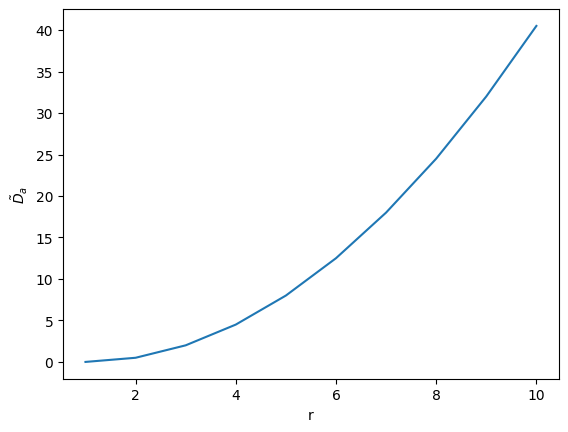

In [45]:
# plotting the integral is more useful:
# A parabola is expected

plt.figure()
plt.plot(rs, int_tDa.vals)
plt.xlabel('r')
plt.ylabel(r'$\tilde{D}_a$')
plt.show()

In [4]:
class SwarzschildRun:
    '''
    Given a starting Grid object and (other parameters), this class can be used to run and handle data throughout a run and (hopefully)
    import and export data using pandas for practicality.

    Attributes:
        startGrid (Grid): Initial slice of the simulation
        history (dict):  
        
    Methods:
        
    '''

    def __init__(self, startGrid):
        self.slice = self.startGrid

Abaixo eu vou tentar uma "implementação direta" do problema, ao invés de buscar por um design orientado a objeto. Vou começar definindo as propriedades do "grid" espacial e as condições iniciais:

In [32]:
# Attempt at direct run of the algorithm

# Grid and simulation parameters:
Dr = 0.01
Dt = Dr/2
ti, tf = 0., 10.
M = 1.
rmin, rmax = 0., 10.
Nr = int((rmax-rmin)/Dr)
r = np.linspace(rmin, rmax, Nr)+Dr/2

# Shifted r vector + fictitious left extension
r_ext = np.zeros(Nr+1)
r_ext[1:] = r
r_ext[0] = -r_shift[1]

# Initial conditions:
tA, tB = 1.+np.zeros(Nr), 1.+np.zeros(Nr)
tDa, tDb = np.zeros(Nr), np.zeros(Nr)
Ka, Kb = np.zeros(Nr), np.zeros(Nr)

Imediatamente, precisamos de duas funções, uma para derivar e outra para integrar nossos vetores $V_r$ em relação a $r$. Para a derivada eu vou usar o algoritmo de diferença central e para as integrais a regra do trapézio, e na célula a seguir eu faço alguns testes dessas funções.

In [59]:
def d_dr(ext_vec, r):
    '''
    Returns a np.array with the spatial derivatives 
    If given, bounds has to be a 2-element (number) list, tuple or array
    ext_vec (np.array (N, ) ): Extended vector to be differentiated ( with a value f(-dx/2)=+/-f(dx/2)
    '''

    diff = np.zeros(len(ext_vec)-1)
    diff[-1] = (ext_vec[-1]-ext_vec[-2])/r[-1]

    # Central difference algorithm for numerical derivative:
    diff[:-1] = (ext_vec[2:]-ext_vec[:-2])/(2*(r[1:]-r[:-1]))
        
    return diff

def int_dr(vec, r, bound):
    '''
    Returns a np.array with the spatial integral of vals, given an initial value integral[0]
    '''
        
    integral = np.zeros(len(vec))
    integral[0]=bound
    
    for i in range(len(vec)-1): #vectorized formula doesn't update the array dynamically
        integral[i+1]=integral[i]+0.5*(r[i+1]-r[i])*(vec[i]+vec[i+1]) #trapezoid rule

    return integral

In [60]:
# Test:
# The numerical implementation presented requires an artificial extension for each function
# Some of them are extended as even functions, while other are extended as odd functions

tA_shift = np.zeros(Nr+1)
tA_shift[1:] = tA
tA_shift[0] = -tA[0]

print('Derivative: ', d_dr(tA_shift, r))
print('Integral: ', int_dr(tA, r, 0))

Derivative:  [99.9  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   

Agora precisamos definir as funções de incremento temporal das nossas variáveis:

In [56]:
def dt_tDa(r, **kwargs):
    # Evolution equation for Da
    
    tA, tB = kwargs['tA'], kwargs['tB']
    tDa, tDb = kwargs['tDa'], kwargs['tDb']
    Ka, Kb = kwargs['Ka'], kwargs['Kb']
    lbda, psi = kwargs['lbda'], kwargs['psi']
    alpha, Dalpha = kwargs['alpha'], kwargs['Dalpha']
    dr_lnpsi = kwargs['dr_lnpsi']
    
    return (-2)*alpha*(Ka*Dalpha+d_dr(Ka, r))

def dt_tDb(r, **kwargs):
    # Evolution equation for Db
    tA, tB = kwargs['tA'], kwargs['tB']
    tDa, tDb = kwargs['tDa'], kwargs['tDb']
    Ka, Kb = kwargs['Ka'], kwargs['Kb']
    lbda, psi = kwargs['lbda'], kwargs['psi']
    alpha, Dalpha = kwargs['alpha'], kwargs['Dalpha']
    dr_lnpsi = kwargs['dr_lnpsi']
    
    return (-2)*alpha*(Kb*Dalpha+d_dr(Kb, r))

def dt_Ka(r, **kwargs):
    # Evolution equation for Ka
    tA, tB = kwargs['tA'], kwargs['tB']
    tDa, tDb = kwargs['tDa'], kwargs['tDb']
    Ka, Kb = kwargs['Ka'], kwargs['Kb']
    lbda, psi = kwargs['lbda'], kwargs['psi']
    alpha, Dalpha = kwargs['alpha'], kwargs['Dalpha']
    dr_lnpsi = kwargs['dr_lnpsi']
    
    mul = alpha/((psi**4)*tA)

    dr_lnpsi = kwargs['dr_lnpsi']

    t1 = d_dr((Dalpha+tDb+4*dr_lnpsi), r)
    t2 = Dalpha**2
    t3 = (tDb+4*dr_lnpsi)**2
    t4 = (Dalpha-tDb-4*dr_lnpsi)*(tDa+4*dr_lnpsi)/2
        
    par = t1+t2+t3-t4
    return (-mul)*par

def dt_Kb(r, **kwargs):
    # Evolution equation for Kb
    tA, tB = kwargs['tA'], kwargs['tB']
    tDa, tDb = kwargs['tDa'], kwargs['tDb']
    Ka, Kb = kwargs['Ka'], kwargs['Kb']
    lbda, psi = kwargs['lbda'], kwargs['psi']
    alpha, Dalpha = kwargs['alpha'], kwargs['Dalpha']
    dr_lnpsi = kwargs['dr_lnpsi']
    
    mul = alpha/(2*(psi**4)*tA)

    dr_lnpsi = kwargs['dr_lnpsi']

    t1 = d_dr((tDb+4*dr_lnpsi), r)
    t2 = Dalpha*(tDb+4*dr_lnpsi)
    t3 = (tDb+4*dr_lnpsi)**2
    t4 = (tDa+4*dr_lnpsi)*(tDb+4*dr_lnpsi)/2
    t5 = (1/r)*(tDa-4*tDb-2*Dalpha-12*dr_lnpsi)
    t6 = 2*lbda/r
        
    par = t1+t2+t3-t4-t5+t6
        
    tout = alpha*Kb*(Ka+2*Kb)
        
    return (-mul)*par+tout

def dt_lbda(r, **kwargs):
    # Evolution equation for lbda
    tA, tB = kwargs['tA'], kwargs['tB']
    tDa, tDb = kwargs['tDa'], kwargs['tDb']
    Ka, Kb = kwargs['Ka'], kwargs['Kb']
    lbda, psi = kwargs['lbda'], kwargs['psi']
    alpha, Dalpha = kwargs['alpha'], kwargs['Dalpha']
    dr_lnpsi = kwargs['dr_lnpsi']
    
    mult = (2*alpha*tA)/tB
        
    par = d_dr(Kb, r)-(tDb+4*dr_lnpsi)*(Ka-Kb)/2

    return mult*par

Falta uma função: A cada passo temporal, no final de tudo, resolve-se uma equação diferencial de segunda ordem em $r$ da função $\alpha$. A seguir, definimos uma função que resolve essa equação diferencial.

In [63]:
def solve_alpha(r, **kwargs):
    # Solves the 2nd order differential equation for alpha(r)
    # Currently implemented: Double trapezoid, possible low accuracy, check other methods in class notes
    tA, tB = kwargs['tA'], kwargs['tB']
    tDa, tDb = kwargs['tDa'], kwargs['tDb']
    Ka, Kb = kwargs['Ka'], kwargs['Kb']
    lbda, psi = kwargs['lbda'], kwargs['psi']
    alpha, Dalpha = kwargs['alpha'], kwargs['Dalpha']
    dr_lnpsi = kwargs['dr_lnpsi']

    # u(r) = \partial_r alpha
    u = np.zeros(len(r))
    u[0] = 0. #boundary condition 1

    dr_u = tA*(psi**4)*(Ka**2+Kb**2)-(2/r+tDb-0.5*tDa+2*dr_lnpsi)*d_dr(alpha, r)
    for i in range(len(r)-1):
        u[i+1] = u[i]+0.5*(r[i+1]-r[i])*(dr_u[i]+dr_u[i+1]) #trapezoid rule

    # now alpha = int u(r)dr, due to the second given boundary, I'll integrate backwards:
    alpha[-1] = 1-r[-1]*u[-1] #solution to boundary condition dr(alpha)=(1-alpha)/r at r->infty
    indices = [len(r)-i for i in range(1, len(r)+1)]
    for i in indices: #these indices might be out of bounds
        alpha[i] = alpha[i+1]-0.5*(r[i+1]-r[i])*(u[i]+u[i+1])
    
    return alpha